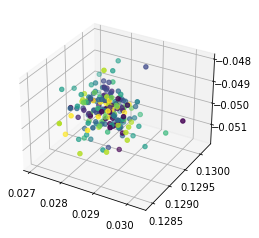

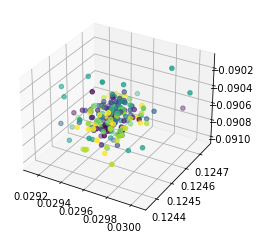

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F


device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

transform = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
          ])

train_set = datasets.FashionMNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=200, shuffle=True)

test_set = datasets.FashionMNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=200, shuffle=True)

train_data_size = len(train_set)
test_data_size = len(test_set)

def tanh_norm(inputs):
    z = torch.tanh(inputs)
    znorm = z / (torch.sqrt(torch.sum(torch.pow(torch.abs(z), 2), axis=1, keepdims=True)))
    return znorm


InputModule = nn.Sequential(            
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(in_features=120, out_features=84)
).to(device)

OutputModule = nn.Sequential(
    
    nn.Tanh(),
    nn.Linear(in_features=84, out_features=10),
).to(device)

def forwardPass_InputModule(x):
    x = InputModule(x)
    return x


def forwardPass_OutputModule(self, x):
    x = self.linear_layer(x)
    x = F.softmax(x, dim=1)
    return x
  


def SRS_Loss(x, y, num_classes):
    def k_mtrx(x0, x1):
        return torch.matmul(tanh_norm(x0), tanh_norm(x1).T)

    def map_input(x):
        return torch.where(
            torch.eye(len(x)) == 1,
                torch.tensor(-float("inf"), dtype=torch.float32),
                k_mtrx(x, x)
            )

    def one_hot_encode(target, n_classes):
        
        if target.ndim > 1:
            target = torch.squeeze(target)
        target_onehot = torch.zeros((target.shape[0], n_classes))
        # target_onehot[range(target.size(0)), target] = 1
        target_onehot[range(target.size(0)), target.type(torch.long)] = 1
        #target_onehot[range(target.shape[0]), target.type(torch.long)] = 1
        return target_onehot

    def get_ideal_k_mtrx(target1, target2, n_classes):
        
        k_min = -1.
        k_max = 1.
        if n_classes < 2:
            raise ValueError('You need at least 2 classes')

        if len(target1.shape) > 2:
            raise ValueError('target1 has too many dimensions')
        if len(target2.shape) > 2:
            raise ValueError('target2 has too many dimensions')

        if torch.max(target1) + 1 > n_classes:
            raise ValueError('target1 has at least one invalid entry')
        if torch.max(target2) + 1 > n_classes:
            raise ValueError('target2 has at least one invalid entry')

        target1_onehot, target2_onehot = \
            one_hot_encode(target1, n_classes).type(torch.float32), \
            one_hot_encode(target2, n_classes).type(torch.float32)
        ideal = torch.matmul(target1_onehot, target2_onehot.T)
        if k_min != 0: # for tanh activation function
            min_mask = torch.full(ideal.shape, k_min)
            ideal = torch.where(ideal == 0, min_mask, ideal) #Same class indices are 1 others -1.

        if k_max != 1: # for ReLU activation function
            max_mask = torch.full_like(ideal, k_max)
            ideal = torch.where(ideal == 1, max_mask, ideal) # Same class indices are MaxValue others 0.
        return ideal

######################### Train the input module #########################


    k_min = -1.
    xx = map_input(x)
    k_ideal = get_ideal_k_mtrx(y, y, num_classes) #We are using phi(tanh) in the first module's training.
    return -torch.mean(torch.exp(xx[k_ideal == k_min]))


optimizer = torch.optim.Adam(params=InputModule.parameters(), lr=1e-3)


num_classes=10
n_epochs=1000

for epoch in range(n_epochs):
    for batch in trainloader:
        inputs, targets = batch
        loss_fn = SRS_Loss(forwardPass_InputModule(inputs), targets, num_classes)
        
        
        optimizer.zero_grad(set_to_none=True)
        loss_fn.backward()
        optimizer.step()
    if (epoch % 5) == 0:
        net_repr = forwardPass_InputModule(inputs).detach().cpu()
        net_repr = tanh_norm(net_repr).numpy()
        #print("Shape {} Target shape {}".format(net_repr.shape,targets.shape))
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(net_repr[:,0],net_repr[:,1],net_repr[:,2],c=targets)
        plt.show()